In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import mutual_info_classif
import unicodedata
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from optuna.samplers import TPESampler
import optuna
import re
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from catboost import Pool
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

c:\Users\Pc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Pc\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [21]:
train = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\train.csv')
test = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\test_x.csv')
submission = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\sample_submission.csv') 

In [305]:
train.fillna('bilinmiyor', inplace = True)

In [55]:
b = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\train.csv')

In [306]:
def yazım_düzeltme(veri):
    if pd.isnull(veri):
        return None
    # 2. String kontrolü
    if not isinstance(veri, str):
        return veri
    küçük_harf = veri.lower()
    return küçük_harf
    
for columns in train.columns:
    train[columns]= train[columns].apply(lambda x: yazım_düzeltme(x))

In [307]:
def bosluk_temizleme(veri):
    if pd.isnull(veri):
        return None
    # 2. String kontrolü
    if not isinstance(veri, str):
        return veri
    boşluksuz = veri.strip()
    son_hali = veri.replace(r'\s+', ' ', regex=True)
    return son_hali

for columns in train.columns:
    train[columns]= train[columns].apply(lambda x: yazım_düzeltme(x))

In [308]:
def hata_temizleme(veri):
    if isinstance(veri, str):  # Sadece string veriler üzerinde işlem yap
        return re.sub(r'[^\w\s]', '', veri)  # Özel karakterleri temizle
    return veri  # String değilse olduğu gibi döndür

# Hariç tutulacak sütunların listesi
hariç_tutulan_sütunlar = [
    "Dogum Tarihi", "Dogum Yeri", "Universite Not Ortalamasi", "Ikametgah Sehri	","Lise Mezuniyet Notu","Lise Sehir", 
    "Baba Egitim Durumu", "Uye Oldugunuz Kulubun Ismi", 
    "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", 
    "Hangi STK'nin Uyesisiniz?"
]

# Belirtilen sütunlar dışında kalan tüm sütunlara hata_temizleme fonksiyonunu uygula
for column in train.columns:
    if column not in hariç_tutulan_sütunlar:
        train[column] = train[column].apply(lambda veri: hata_temizleme(veri))

In [309]:
def turkish_to_english(text):
    if isinstance(text, str):  # Sadece string textler üzerinde işlem yap
        translation_table = str.maketrans("çğıöşü", "cgiosu")  # ı -> i
        return text.translate(translation_table)
    return text  # String değilse olduğu gibi döndür

for column in train.columns:
    train[column] = train[column].apply(lambda x: turkish_to_english(x))

In [310]:
doğru_şehirler = ['adana', 'adiyaman', 'afyonkarahisar', 'agri', 'aksaray', 'amasya', 'ankara', 'antalya', 'ardahan', 'artvin', 'aydin', 'balikesir', 'bartin', 'batman', 'bayburt',
 'bilecik', 'bingol', 'bitlis', 'bolu', 'burdur', 'bursa', 'canakkale', 'cankiri', 'corum', 'denizli', 'diyarbakir', 'duzce', 'edirne', 'elazig', 'erzincan',
 'erzurum', 'eskisehir', 'gaziantep', 'giresun', 'gumushane', 'hakkari', 'hatay', 'igdir', 'isparta', 'istanbul', 'izmir', 'kahramanmaras', 'karabuk', 'karaman',
 'kars', 'kastamonu', 'kayseri', 'kirikkale', 'kirklareli', 'kirsehir', 'kilis', 'kocaeli', 'konya', 'kutahya', 'malatya', 'manisa', 'mardin', 'mersin', 'mugla', 'mus',
 'nevsehir', 'nigde', 'ordu', 'osmaniye', 'rize', 'sakarya', 'samsun', 'siirt', 'sinop', 'sivas', 'sanliurfa', 'sirnak', 'tekirdag', 'tokat', 'trabzon', 'tunceli', 'usak', 'van',
 'yalova', 'yozgat', 'zonguldak']


def sehir_duzelt(sehir, dogru_sehirler):
    # 1. NaN kontrolü
    if pd.isnull(sehir):
        return None
    
    # 2. String kontrolü
    if not isinstance(sehir, str):
        return sehir
    
    # 3. Şehri "/" işareti ile iki parçaya böl
    parcalar = sehir.split('/')
    
    # 4. İlk parçayı (şehir kısmı olduğunu varsayıyoruz) temizle
    sehir_temiz = parcalar[0].strip()
    
    # 5. İlk parçayı doğru şehir listesi ile karşılaştır
    en_yakin_sehir = process.extractOne(sehir_temiz, dogru_sehirler)[0]
    
    # 6. Eğer ilk parça doğru şehirlerden biriyle çok benzer değilse ikinci parçayı kontrol et
    if en_yakin_sehir not in dogru_sehirler and len(parcalar) > 1:
        ikinci_parca = parcalar[1].strip()
        en_yakin_sehir = process.extractOne(ikinci_parca, dogru_sehirler)[0]
    
    return en_yakin_sehir

# Şehir sütununu düzenle
train['Dogum Yeri'] = train['Dogum Yeri'].apply(lambda x: sehir_duzelt(x, doğru_şehirler))

train['Ikametgah Sehri'] = train['Ikametgah Sehri'].apply(lambda x: sehir_duzelt(x, doğru_şehirler))

In [311]:
train['Universite Kacinci Sinif'] = train['Universite Kacinci Sinif'].replace({'0':'hazirlik', 'tez':'yuksek lisans', 'yuksek lisans' : 'mezun'})

In [142]:
train['Universite Kacinci Sinif'].value_counts() # BURAYA BİR DAHA BAK

Universite Kacinci Sinif
2             21773
3             16956
4             13113
1             10260
hazirlik       1311
5               961
bilinmiyor      374
mezun           200
6               177
Name: count, dtype: int64

In [312]:
train['Universite Not Ortalamasi'] = train['Universite Not Ortalamasi'].replace({'3.00 - 3.50' : '3.00-3.50',
                                                                                '3.50-3' : '3.00-3.50', '3.00 - 3.50' : '3.00-3.50',
                                                                                '2.50 - 3.00 ' : '2.50-3.00', '3.50 - 4.00' : '3.50-4.00',
                                                                                '2.00 - 2.50 ' : '2.00-2.50', '2.50 - 2.99' : '2.50-3.00',
                                                                                '3.00 - 3.49' : '3.00-3.50', '2.50 -3.00' : '2.50-3.00',
                                                                                '3.00 - 4.00' : '3.00-4.00', '1.80 - 2.49' : '2.00-2.50',
                                                                                '4-3.5' : '3.50-4.00', '1.00 - 2.50' : '1.00-2.50', '0 - 1.79' : '0-1.79',
                                                                                '4.0-3.5' : '3.50-4.00', '3.00-2.50' : '2.50-3.00', '2.50 - 3.00': '2.50-3.00',
                                                                                 '2.00 - 2.50' : '2.00-2.50', 'ORTALAMA BULUNMUYOR' : 'ortalama yok', 'Not ortalamasi yok' : 'ortalama yok',
                                                                                 'Ortalama bulunmuyor' : 'ortalama yok', '1.00-2.50' : '2.50 ve alti', '0-1.79' : '2.50 ve alti',
                                                                                 '3.00-3.50' : '3.00-4.00', '3.50-4.00' : '3.00-4.00', '2.00-2.50' : '2.50 ve alti', 'Hazirliğim' : 'ortalama yok', 'hazirligim' : 'ortalama yok',
                                                                                 'ortalama bulunmuyor' : 'ortalama yok', 'not ortalamasi yok' : 'ortalama yok'
                                                                                    })

In [313]:
train['Universite Not Ortalamasi'] = train['Universite Not Ortalamasi'].replace({
    '3.00-3.50' : '3.00-4.00', '3.50-4.00' : '3.00-4.00', '2.00,2.50' : '2.50 ve alti',
    '1.00-2.50' : '2.50 ve alti', '0-1.79' : '2.50 ve alti', '2.00-2.50' : '2.50 ve alti', 'ortalama yok' : 'bilinmiyor'})

In [314]:
train.loc[train['Lise Adi'].str.contains('acik', case=False, na=False), 'Lise Adi'] = 'acik ogretim'
train.loc[train['Lise Adi'].str.contains('ogretim', case=False, na=False), 'Lise Adi'] = 'acik ogretim'
train['Lise Adi'].replace({'' : 'bilinmiyor'}, inplace = True)

# Yeni sütunu oluştur ve koşullara göre değerleri atayın
train['Lise Adi Yeni'] = train.apply(
    lambda row: row['Lise Adi'] if row['Lise Adi'] != 'bilinmiyor' else (row['Lise Adi Diger'] if row['Lise Adi Diger'] != 'bilinmiyor' else 'bilinmiyor'),
    axis=1
)

In [315]:
ilçe_il = pd.read_csv(r'C:\Users\Pc\Downloads\ilce_sinirlari.csv')

def turkish_to_english(text):
    if isinstance(text, str):  # Sadece string textler üzerinde işlem yap
        text = text.lower()
        translation_table = str.maketrans("çğıöşü", "cgiosu")  # ı -> i
        return text.translate(translation_table)
    return text  # String değilse olduğu gibi döndür

for column in ilçe_il.columns:
    ilçe_il[column] = ilçe_il[column].apply(lambda x: turkish_to_english(x))

il_ilce_dict = ilçe_il.set_index('ILCE_ADI')['IL_ADI'].to_dict()

train['Lise Sehir'] = train['Lise Sehir'].map(il_ilce_dict).fillna(train['Lise Sehir'])

In [316]:
def normalize_string(s):
    return unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')

train['Lise Sehir'] = train['Lise Sehir'].apply(normalize_string).str.lower().str.strip()

In [317]:
train['Lise Turu'] = train['Lise Turu'].replace({'ozel' : 'ozel lise', 'ozel lisesi' : 'ozel lise', 'meslek' : 'meslek lisesi', 'duz lise' : 'devlet'})

In [318]:
train['Lise Mezuniyet Notu'] = train['Lise Mezuniyet Notu'].replace({
    '75 - 100' : '75-100', '84-70' : '75-100', '100-85' : '75-100',
    '4.00-3.50' : '75-100', '50 - 75' : '50-75', '3.00 - 4.00' : '75-100',
    '3.50-3.00' : '75-100', '3.50-3' : '75-100', '69-55' : '50-75', '3.00-2.50' : '75-100',
    '50 - 74' : '50-75', '2.50 ve alti' : '25-50', '2.50 ve altı' : '25-50', '54-45' : '25-50',
    '25 - 50': '25-50', 'not ortalamasi yok' : '25-50','Not ortalamasi yok' : '25-50',
    '44-0' : '25-50', '0 - 25' : '25-50', '25 - 49' : '25-50','0 - 24' : '25-50',
    'Not ortalaması yok' : '25-50'
}) 

In [260]:
train['Lise Mezuniyet Notu'].value_counts()

Lise Mezuniyet Notu
75-100        52573
50-75          6284
bilinmiyor     5917
25-50           351
Name: count, dtype: int64

In [319]:
train['Lise Mezuniyet Notu'] = train['Lise Mezuniyet Notu'].fillna('bilinmiyor')

In [320]:
# Temizleme fonksiyonu
def temizle_burs_bilgisi(x):
    if pd.isnull(x):
        return x
    if re.search(r'kyk|kredi', x):
        return 'kyk'
    return x

# Değişkeni güncelleme
train['Burs Aldigi Baska Kurum'] = train['Burs Aldigi Baska Kurum'].apply(temizle_burs_bilgisi)

In [321]:
train['Burs Aldigi Baska Kurum'] = train['Burs Aldigi Baska Kurum'].replace({'':'bilinmiyor', 'k' : 'kyk', 'ky' : 'kyk', 'devlet bursu' : 'devlet'})

In [322]:
train['Anne Egitim Durumu'] = train['Anne Egitim Durumu'].replace({'ilkokul mezunu' : 'ilkokul', 'ortaokul mezunu' : 'ortaokul', 'lise mezunu' : 'lise',
                                                                    'universite mezunu' : 'universite', 'yuksek lisans  doktora' : 'doktora',
                                                                    'yuksek lisans  doktara' : 'doktora', 'egitim yok' : 'egitimi yok'})

In [323]:
train['Anne Sektor'] = train['Anne Sektor'].replace({'0' : 'yok' , '' : 'yok'})

In [324]:
def normalize_string(s):
    return unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')

train['Baba Egitim Durumu'] = train['Baba Egitim Durumu'].apply(normalize_string).str.lower().str.strip()

In [325]:
train['Baba Egitim Durumu'] = train['Baba Egitim Durumu'].replace({'ilkokul mezunu' : 'ilkokul', 'ortaokul mezunu' : 'ortaokul', 'lise mezunu' : 'lise',
                                                                    'universite mezunu' : 'universite', 'yuksek lisans / doktora' : 'doktora',
                                                                    'yuksek lisans / doktara' : 'doktora', 'egitim yok' : 'egitimi yok', '0' : 'egitimi yok'})

In [326]:
train['Baba Sektor'] = train['Baba Sektor'].replace({'0' : 'yok' , '' : 'yok'})

In [327]:
def donustur_int64_veya_birak(veri):
    # Eğer veri eksik değilse ve veri zaten bir tam sayiysa veri olduğu gibi birakilir.
    if pd.isnull(veri) or isinstance(veri, int):
        return veri
    # Eğer veri tam sayi değilse ve dönüşebilir durumdaysa tam sayiya çevirilir.
    try:
        return int(veri)
    except (ValueError, TypeError):
        # Dönüşüm başarisiz olursa veri olduğu gibi birakilir.
        return veri

# Her bir hücreyi kontrol ederek uygun işlemi yapiyoruz
train['Kardes Sayisi'] = train['Kardes Sayisi'].apply(donustur_int64_veya_birak)

train['Kardes Sayisi'] = train['Kardes Sayisi'].replace({'kardes sayisi 1 ek bilgi aile hk anne vefat' : '1'})

In [328]:
train['Spor Dalindaki Rolunuz Nedir?'] = train['Spor Dalindaki Rolunuz Nedir?'].replace({'0' : 'yok', '' : 'yok', 'kaptan  lider' : 'kaptan' , 'liderkaptan' : 'kaptan'})

In [84]:
train['Spor Dalindaki Rolunuz Nedir?'].value_counts()

Spor Dalindaki Rolunuz Nedir?
bilinmiyor        32275
yok               15488
diger             10781
kaptan             3709
bireysel           1697
takim oyuncusu     1175
Name: count, dtype: int64

In [329]:
mapping  = {
    "kizilay": [
        "kizilay",
        "kizilay kan bagişi",
        "kizilay afad",
        "yeşilay kizilay",
        "kizil ay",
        "kizilay",
        "turk kizilayi",
        "kizil ay",
        "turk kizilay",
        "kizilay kan bagisi",
        "turk kizilayi",
        "turk kizilayi",
        "turk kizilay"
    ],
    "losev": [
        "losev",
        "losev vakfi",
        "losev ihh",
        "losevv",
        "losemili cocuklar dernegi"
    ],
    "tema": [
        "tema vakfi",
        "t.e.m.a",
        "tema dernegi",
        "tema agac dikim",
        "teema"
    ],
    "tog": [
        "tog vakfi",
        "toplum gonulluleri",
        "toplum gonulluleri vakfi",
        "toplum gonulluleri",
        "tog dernegi"
    ],
    "yeşilay": [
        "yesilay",
        "yeşilay dernegi",
        "yeşilay vakfi",
        "yesil ay",
        "genc yeşilay"
    ],
    "afad": [
        "afad başkanligi",
        "afad vakfi",
        "afaad",
        "afad dernegi",
        "afet ve acil yardim"
    ],
    "ihh": [
        "ihh",
        "ihh vakfi",
        "insani yardim ihh",
        "ihh insani yardim",
        "insan haklari ihh"
    ],
    "tugva": [
        "tugva vakfi",
        "tugva",
        "tugva dernegi",
        "turkiye genclik vakfi",
        "t3 vakfi"
    ],
    "aiesec": [
        "aiesec",
        "ai sec",
        "aiesec",
        "ai seck",
        "aysec"
    ],
    "tusev": [
        "tusev",
        "tusev vakfi",
        "tu se v",
        "turkiye sosyal vakfi",
        "tusevv"
    ],
    "tubitak": [
        "tubitak",
        "tubitak vakfi",
        "tubitak",
        "tubi tak",
        "tubi tak"
    ],
    "akut": [
        "akut dernegi",
        "akut vakfi",
        "akut kurtarma",
        "a kut",
        "akutt"
    ],
    "tegv": [
        "tegv vakfi",
        "tegv dernegi",
        "turkiye egitim gonulluleri",
        "egitim gonulluleri",
        "te gv"
    ],
    "cydd": [
        "cydd",
        "cagdaş yaşami destekleme dernegi",
        "cydd",
        "c ydd",
        "cagdaş yaşam dernegi"
    ],
    "tev": [
        "tev vakfi",
        "tev bursu",
        "t.e.v",
        "tev dernegi",
        "turkiye egitim vakfi",
        "turkiye egitim vakfi",
        "turkiye egitim vakfi",
        "turkiye egitim dernegi",
    ],
    "daruşşafaka": [
        "daruşşafaka",
        "daruşşafaka",
        "darusafaka",
        "daruş safaka",
        "daru şafaka"
    ],
    "greenpeace": [
        "greenpeace",
        "green peace",
        "grenpeace",
        "greenpeace dernegi",
        "greenpeac"
    ],
    "wwf": [
        "wwf",
        "w w f",
        "world wildlife fund",
        "dunya dogayi koruma vakfi",
        "wwf vakfi"
    ],
    "unicef": [
        "unicef",
        "unicef",
        "uni sef",
        "unicef vakfi",
        "uniseff"
    ]
}


def duzelt_veri(veri):
    if pd.isnull(veri) or isinstance(veri, int):
        return veri
    for dogru, yanlislar in mapping.items():
        for yanlis in yanlislar:
            if yanlis in veri:
                return dogru  # Eşleşen bir yanlış varsa doğru ile değiştir
    return veri  # Yanlış bulunmazsa orijinal veri döner

# Uygulayalım
train["Hangi STK'nin Uyesisiniz?"] = train["Hangi STK'nin Uyesisiniz?"].apply(duzelt_veri)

train["Hangi STK'nin Uyesisiniz?"] = train["Hangi STK'nin Uyesisiniz?"].replace({'-' : 'yok', '' : 'yok'})

In [330]:
# Temizleme fonksiyonu
def kategori_belirle(deger):
    if pd.isnull(deger):
        return deger
    deger = deger.strip()
    if deger == 'bilinmiyor':
        return 'bilinmiyor'
    if deger == '-':
        return 'deneyim yok'
    if deger == '':
        return 'deneyim yok'
    kelime_sayisi = len(deger.split())
    if kelime_sayisi > 6:
        return 'deneyim var'
    else:
        return 'deneyim yok'

# Uygulama
train['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'] = train['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].apply(kategori_belirle)

In [331]:
train['Ingilizce Seviyeniz?'] = train['Ingilizce Seviyeniz?'].replace({'0' : 'yok'})

In [332]:
universite_tur_sozluk = {
    "istanbul universitesi": "devlet",
    "hacettepe universitesi": "devlet",
    "bogazici universitesi": "devlet",
    "odtu (orta dogu teknik universitesi)": "devlet",
    "ankara universitesi": "devlet",
    "istanbul teknik universitesi": "devlet",
    "ege universitesi": "devlet",
    "gazi universitesi": "devlet",
    "dokuz eylul universitesi": "devlet",
    "marmara universitesi": "devlet",
    "bilkent universitesi": "ozel",
    "yildiz teknik universitesi": "devlet",
    "suleyman demirel universitesi": "devlet",
    "kocaeli universitesi": "devlet",
    "selcuk universitesi": "devlet",
    "uludag universitesi": "devlet",
    "cukurova universitesi": "devlet",
    "karadeniz teknik universitesi": "devlet",
    "pamukkale universitesi": "devlet",
    "gaziantep universitesi": "devlet",
    "sakarya universitesi": "devlet",
    "akdeniz universitesi": "devlet",
    "ondokuz mayis universitesi": "devlet",
    "dicle universitesi": "devlet",
    "erciyes universitesi": "devlet",
    "firat universitesi": "devlet",
    "inonu universitesi": "devlet",
    "canakkale onsekiz mart universitesi": "devlet",
    "nevsehir haci bektas veli universitesi": "devlet",
    "trabzon universitesi": "devlet",
    "eskisehir osmangazi universitesi": "devlet",
    "mugla sitki kocman universitesi": "devlet",
    "ataturk universitesi": "devlet",
    "istanbul medipol universitesi": "ozel",
    "yalova universitesi": "devlet",
    "mehmet akif ersoy universitesi": "devlet",
    "mardin artuklu universitesi": "devlet",
    "aksaray universitesi": "devlet",
    "istanbul gelisim universitesi": "ozel",
    "isparta uygulamali bilimler universitesi": "devlet",
    "van yuzuncu yil universitesi": "devlet",
    "kirikkale universitesi": "devlet",
    "bilecik seyh edebali universitesi": "devlet",
    "usak universitesi": "devlet",
    "nigde omer halisdemir universitesi": "devlet",
    "bartin universitesi": "devlet",
    "siirt universitesi": "devlet",
    "kastamonu universitesi": "devlet",
    "balikesir universitesi": "devlet",
    "kilis 7 aralik universitesi": "devlet",
    "ordu universitesi": "devlet",
    "bayburt universitesi": "devlet",
    "hatay mustafa kemal universitesi": "devlet",
    "gumushane universitesi": "devlet",
    "bozok universitesi": "devlet",
    "adiyaman universitesi": "devlet",
    "sivas cumhuriyet universitesi": "devlet",
    "bitlis eren universitesi": "devlet",
    "istanbul sabahattin zaim universitesi": "ozel",
    "bogazici universitesi": "devlet",
    "anadolu universitesi": "devlet",
    "dokuz eylul universitesi": "devlet",
    "orta dogu teknik universitesi": "devlet",
    "trakya universitesi": "devlet",
    "karabuk universitesi": "devlet",
    "beykent universitesi": "ozel",
    "yeditepe universitesi": "ozel",
    "firat universitesi": "devlet",
    "dumlupinar universitesi": "devlet",
    "canakkale onsekiz mart universitesi": "devlet",
    "koc universitesi": "ozel",
    "ondokuz mayis universitesi": "devlet",
    "bahcesehir universitesi": "ozel",
    "istanbul aydin universitesi": "ozel",
    "mersin universitesi": "devlet",
    "istanbul bilgi universitesi": "ozel",
    "istanbul gelisim universitesi": "ozel",
    "adiyaman universitesi": "devlet",
    "abant izzet baysal universitesi": "devlet",
    "bingol universitesi": "devlet",
    "mugla sitki kocman universitesi": "devlet",
    "celal bayar universitesi": "devlet",
    "aydin adnan menderes universitesi": "devlet",
    "demiroglu bilim universitesi": "ozel",
    "hasan kalyoncu universitesi": "ozel",
    "tunceli universitesi": "devlet",
    "ardahan universitesi": "devlet",
    'istanbul okan universitesi' : 'ozel',
    'dogus universitesi' : 'ozel',
    'ozyegin universitesi' : 'ozel',
    'nisantasi universitesi' : 'ozel',
    'mef universitesi' : 'ozel',
    'sabanci universitesi' : 'ozel',
    'kadir has universitesi' : 'ozel'
}


def üni_tür(veri):
    if pd.isna(veri):  # Eğer veri NaN ise None dondür
        return 'bilinmiyor'
    for universite, tür in universite_tur_sozluk.items():
        if universite in veri:  # Veri üniversite adı içeriyorsa ili dondür (küçük harflerle kontrol)
            return tür
    return 'bilinmiyor'  # Eşleşme bulunmazsa 'bilinmiyor' dondür

# 'Ikametgah Sehri' None olan satırlar için 'Universite Adi' sütununu kullanarak ikametgah düzeltme işlemi
train.loc[train["Universite Turu"] == 'bilinmiyor', 'Universite Turu'] = train[train["Universite Turu"] == 'bilinmiyor']["Universite Adi"].apply(üni_tür)


In [333]:
def extract_year(row):
    dogum_tarihi = row['Dogum Tarihi']
    basvuru_yili = row['Basvuru Yili']
    
    # Bilinmiyor kontrolü
    if 'bilinmiyor' in str(dogum_tarihi).lower():
        return 'bilinmiyor'
    
    try:
        if basvuru_yili == 2014:
            # Ay/Gün/Yıl formatından yıl al
            return dogum_tarihi.split('/')[-1]
        elif basvuru_yili == 2015:
            # Gün-Ay-Yıl formatından yıl al
            return dogum_tarihi.split('-')[-1]
        elif basvuru_yili == 2016:
            # Yıl-Ay-Gün formatından yıl al
            return dogum_tarihi.split('-')[0]
        elif basvuru_yili == 2017:
            # Hem Gün/Ay/Yıl hem de Ay/Gün/Yıl formatı olabilir, yıl her zaman son element olmalı
            return dogum_tarihi.split('/')[-1]
        elif basvuru_yili in [2018, 2019]:
            # Gün/Ay/Yıl formatından yıl al
            return dogum_tarihi.split('/')[-1]
        elif basvuru_yili in [2020, 2021]:
            # Gün/Ay/Yıl formatı, Yıl iki haneli olabilir, saat olabilir
            year = dogum_tarihi.split('/')[-1].split(' ')[0]
            if len(year) == 2:
                # 00-99 yılları 1900 ve 2000'lere göre ayrılabilir
                return '19' + year if int(year) > 20 else '20' + year
            return year
        elif basvuru_yili == 2022:
            # 1.01.2001 00:00 formatından yıl al
            return dogum_tarihi.split('.')[-1].split(' ')[0]
        else:
            return 'bilinmiyor'
    
    except Exception as e:
        print(f"Hata: {dogum_tarihi} -> {e}")
        return 'bilinmiyor'

# Yılı çıkarın
train['Yil'] = train.apply(extract_year, axis=1)

In [334]:
aylar = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12",
    "Ocak": "01", "Şubat": "02", "Mart": "03", "Nisan": "04", "Mayıs": "05", "Haziran": "06", "Temmuz": "07", "Ağustos": "08", "Eylül": "09", "Ekim": "10", "Kasım": "11", "Aralık": "12",
    "Aralik": "12", "Mayis": "05"  # Türkçe hatalı ay isimlerini de düzeltiyoruz
}

def extract_year(dogum_tarihi):
    # Eğer veri sadece yıl ise (örneğin '2000', '1999'), direkt döndür
    if dogum_tarihi.isdigit():
        return dogum_tarihi
    
    # İngilizce ve Türkçe ayları tanıyıp, formatı düzeltme
    for key, value in aylar.items():
        if key in dogum_tarihi:
            dogum_tarihi = dogum_tarihi.replace(key, value)
    
    try:
        # Eğer format 'Gün Ay Yıl' şeklindeyse (örn. 5 Aralik 1993)
        year = dogum_tarihi.split()[-1]  # Son kelime yıl olmalı
        if year.isdigit() and len(year) == 4:  # Yıl dört haneli ise
            return year
        else:
            return 'bilinmiyor'  # Eğer yıl düzgün değilse
    except Exception as e:
        print(f"Hata: {dogum_tarihi} -> {e}")
        return 'bilinmiyor'

# Yılı çıkar
train['Yil'] = train['Yil'].apply(extract_year)

In [335]:
train['Yil'].replace({
    '60': 1960, '61': 1961, '62': 1962, '63': 1963, '64': 1964, '65': 1965, '66': 1966, '67': 1967, '68': 1968, '69': 1969,
    '70': 1970, '71': 1971, '72': 1972, '73': 1973, '74': 1974, '75': 1975, '76': 1976, '77': 1977, '78': 1978, '79': 1979,
    '80': 1980, '81': 1981, '82': 1982, '83': 1983, '84': 1984, '85': 1985, '86': 1986, '87': 1987, '88': 1988, '89': 1989,
    '90': 1990, '91': 1991, '92': 1992, '93': 1993, '94': 1994, '95': 1995, '96': 1996, '97': 1997, '98': 1998, '99': 1999,
    '00': 2000, '01': 2001, '02': 2002, '03': 2003, '04': 2004, '05': 2005, '06': 2006, '07': 2007, '08': 2008, '09': 2009
}, inplace=True)

In [336]:
def str_to_int(value):
    if value == 'bilinmiyor':
        return value
    try:
        return int(value)
    except ValueError:
        return value

# Uygulama
train['Yil'] = train['Yil'].apply(str_to_int)

In [337]:
train['Yil'] = train['Yil'].replace({
    1197 : 1997, 1196: 1996, 1199 : 1999, 9951 : 1951, 9691 : 1961, 1195 : 1995,
    1198 : 1998, 9590 : 1990, 1155 : 1955, 7199 : 1999, 5778 : 1978, 1896 : 1996,
    1895 : 1995, 996 : 1996, 194 : 1994, 2996 : 1996, 9941 : 1941, 1194 : 1994
})

In [338]:
train['Yil'] = train['Yil'].replace({'bilinmiyor' : 1996})

train['Yil'] = train['Yil'].astype('int64')

train['Basvuru Yili'] = train['Basvuru Yili'].astype('int64')

train['yaş'] = train['Basvuru Yili'] - train['Yil']

In [339]:
def yas_grubu(yas):
    if yas < 0:
        return 'bilinmiyor'
    elif 0 <= yas < 14:
        return 'cocuk'
    elif 14 <= yas <= 19:
        return 'ergen'
    elif 19 <= yas <= 24:
        return 'genc'
    elif 24 <= yas <= 30:
        return 'orta yasli'
    else:
        return 'deneyimli'

train['yaş_grubu'] = train['yaş'].apply(yas_grubu)

In [340]:
egitim_durumu_puanlama = {
    'bilinmiyor': 0,
    'egitimi yok': 1,
    'ilkokul': 2,
    'ortaokul': 3,
    'lise': 4,
    'universite': 5,
    'yuksek lisans': 6,
    'doktora': 7
}

train['Anne Egitim Durumu Puan'] = train['Anne Egitim Durumu'].map(egitim_durumu_puanlama)
train['Baba Egitim Durumu Puan'] = train['Baba Egitim Durumu'].map(egitim_durumu_puanlama)

train['Ortalama Egitim Puan'] = (train['Anne Egitim Durumu Puan'] + train['Baba Egitim Durumu Puan']) / 2

In [341]:
def classify_membership(row):
    if row['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] == 'evet':
        if row['Aktif olarak bir STK üyesi misiniz?'] == 'evet':
            return 'girisimci ve sosyal'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'hayir':
            return 'girisimci ama sosyal degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'bilinmiyor':
            return 'girisimci ama sosyal degil'
    elif row['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] == 'hayir':
        if row['Aktif olarak bir STK üyesi misiniz?'] == 'evet':
            return 'sosyal ama girisimci degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'hayir':
            return 'sosyal degil ve girisimci degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'bilinmiyor':
            return 'sosyal degil ve girisimci degil'
    return 'bilinmiyor'

train['girisimci_stk_etiket'] = train.apply(classify_membership, axis=1)

In [342]:
# Türkiye'deki ilk 10 büyük sehir
buyuk_sehirler = ['istanbul', 'ankara', 'izmir', 'bursa', 'antalya', 'adana', 'konya', 'eskisehir','eskisehir' 'kocaeli', 'mugla', 'mersin']

# Yeni sütunları olustur
train['dogum_ikametgah'] = (train['Dogum Yeri'] == train['Ikametgah Sehri']).astype(int)
train['buyuk_sehir'] = train['Ikametgah Sehri'].apply(lambda x: 1 if x in buyuk_sehirler else 0)

In [343]:
train.loc[train['Burslu ise Burs Yuzdesi'] == 'bilinmiyor', 'Burslu ise Burs Yuzdesi'] = 0.0

train['Burslu ise Burs Yuzdesi'] = train['Burslu ise Burs Yuzdesi'].astype('float64')

# Yüzdeyi sayıya dönüştürme ve koşullara göre dönüştürme
def burs_yuzdesi_donustur(yuzde):
    if isinstance(yuzde, str) and yuzde.startswith('%'):
        yuzde = float(yuzde.strip('%'))  # Yüzde işareti kaldır ve sayıya dönüştür
    elif isinstance(yuzde, (int, float)):  # Eğer sayısal değer ise, doğrudan kullan
        yuzde = float(yuzde)
    else:
        return None  # Format uyumsuz ise None döndür

    if yuzde == 0.0:
        return 0.0
    elif yuzde == 25.0:
        return 0.25
    elif yuzde == 50.0:
        return 0.50
    elif yuzde == 75.0:
        return 0.75
    elif yuzde == 100.0:
        return 1.0
    elif 0.0 < yuzde < 25.0:
        return 0.25
    elif 25.0 < yuzde < 50.0:
        return 0.50
    elif 50.0 < yuzde < 75.0:
        return 0.75
    elif 75.0 < yuzde < 100.0:
        return 1.0
    else:
        return yuzde  # Diğer durumlar için

# Yeni bir sütun oluştur ve dönüştürme fonksiyonunu uygula
train['Burs'] = train['Burslu ise Burs Yuzdesi'].apply(burs_yuzdesi_donustur)

In [344]:
# Fonksiyon: Satırda sayısal değeri bul, sadece sayıyı çıkar
def extract_numeric(row):
    # Düzenli ifadeyle (regex) satırdaki sayısal değerleri bul
    numbers = re.findall(r'\d+', row)
    if numbers:
        # Eğer sayısal bir değer bulunursa, birinci değeri döndür
        return numbers[0]
    else:
        # Sayısal değer yoksa satırı olduğu gibi döndür
        return row

# Apply fonksiyonu ile her satırı işleyin
train['Burs Miktarı Temiz'] = train['Baska Kurumdan Aldigi Burs Miktari'].apply(extract_numeric)

In [345]:
train['Burs Miktarı Temiz'].replace({'burs almiyor' : 0, '0' : 0, 'diger' : 600, 'yurt ve yemekhane bursu' : 510,  'daha onceden bu kurumdan bir burs almadim' : 0,
                                     'geri odemeli kyk bursu' : 425, 'yok' : 0, 'kyk bursu kadar' : 425, 'her sene belirlenen miktari' : 425, 'burs almiyorum' : 0,
                                     'spor genclik bakanligi' : 425, '.' : 0, 'cince dil bursu' : 500, 'almiyorum henuz' : 0, 'degisiyordu her sene' : 425, 'kyk' : 425,
                                     'bin türk lirasi' : 1000, 'yurt bursum var' : 300,'yurt bursu' : 300, 'yillik belirlenen kapsamli burs kadar' : 833, 'kyk' : 425,
                                     'nakit burs degil. yurt ücretim odeniyor.' : 350, 'Ücyüz lira' : 300, 'tam burslu oldugum icin yalniz egitim ücreti ek burs almiyorum' : 0,
                                     '300500' : 400, '' : 'bilinmiyor'
                                     },
                                     inplace=True)

In [346]:
tier1 = [
    "koc universitesi", "hacettepe universitesi", "orta dogu teknik universitesi",
    "yildiz teknik universitesi", "istanbul teknik universitesi", "istanbul universitesi",
    "sabanci universitesi", "gazi universitesi", "bogazici universitesi",
    "istanbul universitesi", "cerrahpasa", "istanbul universitesi-cerrahpasa", "ihsan dogramaci bilkent universitesi",
    "ihsan dogramaci bilkent"
]

tier2 = [
    "gebze teknik universitesi", "marmara universitesi", "ankara universitesi",
    "erciyes universitesi", "ataturk universitesi","ege universitesi",
    "dokuz eylul universitesi", "firat universitesi","cukurova universitesi"
]

tier3 = [
    "izmir yuksek teknoloji enstitusu", "karadeniz teknik universitesi", "selcuk universitesi",
    "akdeniz universitesi", "acibadem mehmet ali aydinlar universitesi", "19 mayis universitesi",
    "bursa uludag universitesi", "bezm-i alem vakif universitesi", "saglik bilimleri universitesi",
    "eskisehir osmangazi universitesi"
]

tier4 = [
    "sakarya universitesi", "inonu universitesi", "cankaya universitesi", "kocaeli universitesi",
    "izmir kâtip celebi universitesi", "suleyman demirel universitesi",
    "ankara yildirim beyazit universitesi", "istanbul medeniyet universitesi",
    "van 100. yil universitesi", "istanbul medipol universitesi"]

tier5 = [
    "gaziantep universitesi", "necmettin erbakan universitesi", "mersin universitesi", 
    "anadolu universitesi", "yeditepe universitesi", "bolu abant izzet baysal universitesi", 
    "eskisehir teknik universitesi", "pamukkale universitesi", 
    "tobb ekonomi ve teknoloji universitesi", "abdullah gul universitesi"
]

# Tier 6 üniversiteleri (küçük harfler ve Türkçe karakter dönüşümü)
tier6 = [
    "manisa celal bayar universitesi", "recep tayyip erdogan universitesi", "baskent universitesi", 
    "sivas cumhuriyet universitesi", "harran universitesi", "duzce universitesi", 
    "istinye universitesi", "mugla sitki kocman universitesi", 
    "aydin adnan menderes universitesi", "karabuk universitesi"
]

# Tier 7 üniversiteleri (küçük harfler ve Türkçe karakter dönüşümü)
tier7 = [
    "canakkale 18 mart universitesi", "konya teknik universitesi", "ozyegin universitesi", 
    "bahcesehir universitesi", "kadir has universitesi", "bingol universitesi", 
    "nigde omer halisdemir universitesi", "kahramanmaras sutcu imam universitesi", 
    "atilim universitesi", "afyon kocatepe universitesi"
]

# Tier 8 üniversiteleri
tier8 = [
    "tekirdag namik kemal universitesi", "karamanoglu mehmetbey universitesi", 
    "bursa teknik universitesi", "trakya universitesi", 
    "adana alparslan turkes bilim ve teknoloji universitesi", 
    "bartin universitesi", "aksaray universitesi", 
    "hasan kalyoncu universitesi", "kirikkale universitesi", "hitit universitesi"
]

# Tier 9 üniversiteleri
tier9 = [
    "kastamonu universitesi", "erzurum teknik universitesi", 
    "biruni universitesi", "tokat gaziosmanpasa universitesi", 
    "isparta uygulamali bilimler universitesi", "iskenderun teknik universitesi", 
    "ordu universitesi", "zonguldak bulent ecevit universitesi", 
    "yozgat bozok universitesi", "erzincan binali yildirim universitesi"
]

# Tier 10 üniversiteleri
tier10 = [
    "hatay mustafa kemal universitesi", "dicle universitesi", 
    "burdur mehmet akif ersoy universitesi", "balikesir universitesi", 
    "adiyaman universitesi", "cankiri karatekin universitesi", 
    "siirt universitesi", "izmir ekonomi universitesi", 
    "yasar universitesi", "kirsehir ahi evran universitesi"
]

def belirle_tier(universite):
    if universite in tier1:
        return 'tier1'
    elif universite in tier2:
        return 'tier2'
    elif universite in tier3:
        return 'tier3'
    elif universite in tier4:
        return 'tier4'
    elif universite in tier5:
        return 'tier5'
    elif universite in tier6:
        return 'tier6'
    elif universite in tier7:
        return 'tier7'
    elif universite in tier8:
        return 'tier8'
    elif universite in tier9:
        return 'tier9'
    elif universite in tier10:
        return 'tier10'
    else:
        return 'tier11'

train['Universite Rank'] = train['Universite Adi'].apply(belirle_tier)

In [347]:
ozel_universiteler = [
    "koc universitesi",
    "sabanci universitesi",
    "bilkent universitesi",
    "isletme universitesi",
    "bahcesehir universitesi",
    "kadir has universitesi",
    "yeditepe universitesi",
    "maltepe universitesi",
    "istanbul 29 mayis universitesi",
    "ozyegin universitesi"
]


def belirle_burs(row):
    universite_adi = row['Universite Adi']
    universite_turu = row['Universite Turu']
    burs_yuzdesi = row['Burslu ise Burs Yuzdesi']
    
    if universite_turu == 'devlet' or universite_turu == 'bilinmiyor':
        return 'diger'
    elif universite_turu == 'ozel':
        if universite_adi in ozel_universiteler:
            if burs_yuzdesi and burs_yuzdesi > 75:
                return 'elit'
            elif burs_yuzdesi and burs_yuzdesi <= 75:
                return 'iyi'
            else:
                return 'diger'
        else:
            if burs_yuzdesi and burs_yuzdesi > 75:
                return 'kotunun iyisi'
            else:
                return 'rezil'
    else:
        return 'diger'

train['uni_burs'] = train.apply(belirle_burs, axis=1)

In [348]:
def belirle_not_ort(row):
    universite_adi = row['Universite Adi']
    not_ortalama = row['Universite Not Ortalamasi']
    if universite_adi in tier1 and not_ortalama == '3.00-4.00':
        return 1
    else:
        return 0

train['üni_not_ort'] = train.apply(belirle_not_ort, axis=1)

In [349]:
elit_egitim_durumu = ['lise', 'universite', 'yuksek lisans', 'doktora']

def belirle_aile_egitim(row):
    anne_egitim = row['Anne Egitim Durumu']
    baba_egitim = row['Baba Egitim Durumu']
    if anne_egitim in elit_egitim_durumu and baba_egitim in elit_egitim_durumu:
        return 1
    else:
        return 0

train['Aile Egitim Durumu'] = train.apply(belirle_aile_egitim, axis=1)

In [350]:
baba_egitim_durumu = ['universite', 'yuksek lisans', 'doktora']

def belirle_baba_calismasi(row):
    baba_egitim = row['Baba Egitim Durumu']
    baba_calismasi = row['Baba Calisma Durumu']
    if baba_egitim in baba_egitim_durumu and baba_calismasi == 'emekli':
        return 1
    else:
        return 0

# Yeni sütunu ekleme ve değerleri belirleme
train['Baba_Calisma_Durumu'] = train.apply(belirle_baba_calismasi, axis=1)

In [351]:
# Evet/Hayır dönüşümü
def yes_no_to_binary(value):
    return 1 if value == 'evet' else 0

# İngilizce seviyesine göre dönüşüm
def english_level_to_binary(value):
    return 1 if value == 'ileri' else 0

# Genel girişimci değerlendirmeyi oluşturma
train['genel_girişimci_degerlendirme'] = (
    train['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].apply(yes_no_to_binary) +
    train['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].apply(yes_no_to_binary) +
    train['Aktif olarak bir STK üyesi misiniz?'].apply(yes_no_to_binary) +
    train['Stk Projesine Katildiniz Mi?'].apply(yes_no_to_binary) +
    train['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].apply(yes_no_to_binary) +
    train['Ingilizce Biliyor musunuz?'].apply(yes_no_to_binary) +
    train['Ingilizce Seviyeniz?'].apply(english_level_to_binary)
)


In [352]:
train['Burs Miktarı Temiz'] = train['Burs Miktarı Temiz'].replace({'bilinmiyor' : 0, 'bin turk lirasi' : 1000, 'tam burslu oldugum icin yalniz egitim ucreti ek burs almiyorum' : 0,
                                                                   'ucyuz lira' : 300, 'nakit burs degil yurt ucretim odeniyor' : 250})
train['Burs Miktarı Temiz'] = train['Burs Miktarı Temiz'].astype('float64')

In [353]:
train.loc[train['Kardes Sayisi'] == 'bilinmiyor', 'Kardes Sayisi'] = 2

train['Kardes Sayisi'] = train['Kardes Sayisi'].astype('int64')

In [354]:
train['Kardes Sayisi'] = train['Kardes Sayisi'].apply(lambda x: 6 if x > 5 else x)

In [355]:
train['Degerlendirme Puani'] = train['Degerlendirme Puani'].replace({'bilinmiyor' : None})
train['Degerlendirme Puani'] = train['Degerlendirme Puani'].astype('float64')
train['Degerlendirme Puani'] = train['Degerlendirme Puani'].fillna(train['Degerlendirme Puani'].mean())

In [356]:
# Sözel kategorisi için
sozel_varyasyonlari = ['ts', 'turkcesosyal', 'sozel', 'sosyal', 'turkce sosyal', 'turkce  sosyal','sozel turkce  sosyal'
                       'muhasebe', 'cocuk gelisimi', 'dis ticaret', 'cocuk gelisimi ve egitimi']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    train.loc[train['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'sozel'

In [357]:
# Sözel kategorisi için
sozel_varyasyonlari = ['mf', 'matematik fen', 'matematikfen', 'fen', 'fen matematik', 'matematik  fen','sayisal',
                       'fen  matematik', 'mfmatematikfen', 'matematikfen bilimleri', 'matematik fen sayisal', 'elektrik',
                       'bilgisayar', 'bilisim', 'makina', 'makine', 'grafik', 'dogalgaz', 'elektirk', 'web', 'fm', 'insaat', 'elektronik', 'veri']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    train.loc[train['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'sayisal'

In [358]:
# Sözel kategorisi için
sozel_varyasyonlari = ['esit', 'turkce  matematik', 'turkce matematik', 'turkcematematik', 'tm', 'ea', 'turkcematemetik', 'yiyecek icecek hizmetleri',
                       'muhasebe ve finansman', 'muhasebe finansman', 'muhasebe']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    train.loc[train['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'esit agirlik'

In [359]:
# Sözel kategorisi için
sozel_varyasyonlari = ['yabanci dil', 'dil alani', 'ingilizce', 'almanca', 'fransizca', 'dil']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    train.loc[train['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'dil'

In [360]:
train['Lise Bolumu'] = train['Lise Bolumu'].replace({
    'yok' : 'bilinmiyor', '' : 'bilinmiyor', 'bolum yok' : 'bilinmiyor', 'alan yok': 'bilinmiyor'
})

In [361]:
value_counts = train['Lise Bolumu'].value_counts()
to_replace = value_counts[value_counts < 10].index
train['Lise Bolumu'] = train['Lise Bolumu'].replace(to_replace, 'diger')

In [362]:
train['Lise Turu'] = train['Lise Turu'].replace({
    'meslek lisesi' : 'devlet', 'imam hatip lisesi' : 'devlet', 'fen lisesi' : 'devlet',
    'anadolu lisesi' : 'devlet', 'diger' : 'devlet', 'bilinmiyor' : 'devlet'
})

In [363]:
train['Lise Bolumu'] = train['Lise Bolumu'].replace({
    'bilinmiyor' : 'sayisal', 'diger' : 'sayisal'
})

In [364]:
train['Anne Calisma Durumu'] = train['Anne Calisma Durumu'].replace({
    'emekli' : 'hayir', 'bilinmiyor' : 'hayir'
})

In [365]:
train['Anne Sektor'] = train['Anne Sektor'].replace({
    'bilinmiyor' : 'yok'
})

In [366]:
train['Baba Calisma Durumu'] = train['Baba Calisma Durumu'].replace({
    'emekli' : 'hayir', 'bilinmiyor' : 'hayir'
})

In [367]:
train['Baba Sektor'] = train['Baba Sektor'].replace({
    'bilinmiyor' : 'yok'
})

In [368]:
train["Hangi STK'nin Uyesisiniz?"] = train["Hangi STK'nin Uyesisiniz?"].replace({
    'bilinmiyor' : 'yok'
})

In [369]:
train['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = train['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].replace({
    'bilinmiyor' : 'hayir'
})

In [370]:
train['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'] = train['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].replace({
    'bilinmiyor' : 'deneyim yok'
})

In [371]:
train['Ingilizce Biliyor musunuz?'] = train['Ingilizce Biliyor musunuz?'].replace({
    'bilinmiyor' : 'evet'
})

In [298]:
train['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].value_counts()

Girisimcilikle Ilgili Deneyiminiz Var Mi?
hayir    43981
evet     15931
Name: count, dtype: int64

In [374]:
train.to_csv('15 eylül 16.13 train.csv', index = False)

In [2]:
train = pd.read_csv(r'C:\Users\Pc\Desktop\btk\14 eylül 21.58.csv')

In [264]:
column_groups = {
    'categorical_columns' : ["Cinsiyet", "Dogum Yeri", "Ikametgah Sehri", "Universite Adi", "Universite Turu",
                             "Burs Aliyor mu?", "Bölüm", "Universite Kacinci Sinif", "Universite Not Ortalamasi",
                             "Lise Adi Yeni", "Lise Sehir", "Lise Turu",
                             "Lise Bolumu", "Lise Mezuniyet Notu", "Baska Bir Kurumdan Burs Aliyor mu?", "Burs Aldigi Baska Kurum",
                             "Anne Egitim Durumu", "Anne Calisma Durumu", "Anne Sektor", "Baba Egitim Durumu", "Baba Calisma Durumu",
                             "Baba Sektor", "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?",
                             "Profesyonel Bir Spor Daliyla Mesgul musunuz?", "Spor Dalindaki Rolunuz Nedir?", "Aktif olarak bir STK üyesi misiniz?",
                             "Hangi STK'nin Uyesisiniz?", "Stk Projesine Katildiniz Mi?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?",
                             "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", "Ingilizce Biliyor musunuz?", "Ingilizce Seviyeniz?",
                             "yaş_grubu", "girisimci_stk_etiket", "uni_burs","Universite Rank"],
    'numerical_columns' : ['yaş', 'Anne Egitim Durumu Puan', 'Baba Egitim Durumu Puan', 'Burs','Burs Miktarı Temiz', 'dogum_ikametgah',
                           'buyuk_sehir','Kardes Sayisi', 'Ortalama Egitim Puan', 'üni_not_ort','Aile Egitim Durumu', 'genel_girişimci_degerlendirme'],
    'target'            : ['Degerlendirme Puani']
}

In [271]:
training_columns = column_groups['categorical_columns'] + column_groups['numerical_columns']

In [273]:
categorical_columns =["Cinsiyet", "Dogum Yeri", "Ikametgah Sehri", "Universite Adi", "Universite Turu",
                             "Burs Aliyor mu?", "Bölüm", "Universite Kacinci Sinif", "Universite Not Ortalamasi",
                             "Lise Adi Yeni", "Lise Sehir", "Lise Turu",
                             "Lise Bolumu", "Lise Mezuniyet Notu", "Baska Bir Kurumdan Burs Aliyor mu?", "Burs Aldigi Baska Kurum",
                             "Anne Egitim Durumu", "Anne Calisma Durumu", "Anne Sektor", "Baba Egitim Durumu", "Baba Calisma Durumu",
                             "Baba Sektor", "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?",
                             "Profesyonel Bir Spor Daliyla Mesgul musunuz?", "Spor Dalindaki Rolunuz Nedir?", "Aktif olarak bir STK üyesi misiniz?",
                             "Hangi STK'nin Uyesisiniz?", "Stk Projesine Katildiniz Mi?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?",
                             "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", "Ingilizce Biliyor musunuz?", "Ingilizce Seviyeniz?",
                             "yaş_grubu", "girisimci_stk_etiket", "uni_burs","Universite Rank"]

numeric_columns = column_groups['numerical_columns']

In [274]:
for columns in categorical_columns:
    train[columns] = train[columns].astype('str')
for columns in numeric_columns:
    train[columns] = train[columns].astype('int64')

In [276]:
train = train[train['Basvuru Yili'] != 2016]

In [269]:
params = {'iterations': 1336,
 'learning_rate': 0.06268646156028766,
 'depth': 7,
 'l2_leaf_reg': 1.5357100803648207,
 'bagging_temperature': 0.8749385252661529,
 'random_strength': 7.538878114425933}

In [275]:
kf = KFold(n_splits=10)

cv_scores = []

oof_data, non_oof_train_data = train_test_split(train, test_size=0.9, random_state = 34)
        
for fold, (train_index, test_index) in enumerate(kf.split(non_oof_train_data[training_columns]), 1):     
    print("*" * 50)
    print(f"FOLD: {fold}")

    X_train_fold, X_test_fold = non_oof_train_data.iloc[train_index], non_oof_train_data.iloc[test_index]
    y_train_fold, y_test_fold = X_train_fold['Degerlendirme Puani'], X_test_fold['Degerlendirme Puani']

    train_pool = Pool(X_train_fold[training_columns], 
                      y_train_fold, cat_features=categorical_columns)
    test_pool = Pool(X_test_fold[training_columns],
                     y_test_fold, cat_features=categorical_columns)

    model = CatBoostRegressor(**params, task_type='GPU', loss_function='RMSE', cat_features=categorical_columns, verbose=100, random_state=42, early_stopping_rounds=10)
    model.fit(train_pool)

    # Test seti üzerinde tahmin yapma
    y_pred = model.predict(X_test_fold[training_columns])

    # RMSE hesaplama
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
    print(f"\{fold}_rmse: {rmse:.4f}")
    cv_scores.append(rmse)

model = CatBoostRegressor(**params, task_type='GPU', loss_function='RMSE', cat_features=categorical_columns, verbose=100, random_state=42,early_stopping_rounds=10)
train_pool_oof = Pool(oof_data[training_columns], 
                  oof_data['Degerlendirme Puani'], cat_features=categorical_columns)
model.fit(train_pool_oof)

y_pred_oof = model.predict(oof_data[training_columns])
rmse_oof = np.sqrt(mean_squared_error(oof_data['Degerlendirme Puani'], y_pred_oof))

print(f"\naverage_rmse: {np.mean(cv_scores):.4f}")
print(f"oof_rmse: {rmse_oof:.4f}")   

**************************************************
FOLD: 1
0:	learn: 14.6357367	total: 128ms	remaining: 2m 50s
100:	learn: 6.3003276	total: 9.29s	remaining: 1m 53s
200:	learn: 6.0046523	total: 18.2s	remaining: 1m 42s
300:	learn: 5.8906785	total: 27.2s	remaining: 1m 33s
400:	learn: 5.8475210	total: 35.7s	remaining: 1m 23s
500:	learn: 5.8135259	total: 44.7s	remaining: 1m 14s
600:	learn: 5.7900342	total: 53.7s	remaining: 1m 5s
700:	learn: 5.7723973	total: 1m 3s	remaining: 57.9s
800:	learn: 5.7567022	total: 1m 13s	remaining: 49.1s
900:	learn: 5.7369227	total: 1m 24s	remaining: 40.6s
1000:	learn: 5.7238356	total: 1m 35s	remaining: 31.8s
1100:	learn: 5.7113180	total: 1m 47s	remaining: 22.9s
1200:	learn: 5.6981063	total: 1m 58s	remaining: 13.4s
1300:	learn: 5.6868339	total: 2m 9s	remaining: 3.5s
1335:	learn: 5.6839932	total: 2m 14s	remaining: 0us
\1_rmse: 5.9986
**************************************************
FOLD: 2
0:	learn: 14.6218773	total: 125ms	remaining: 2m 47s
100:	learn: 6.3013595

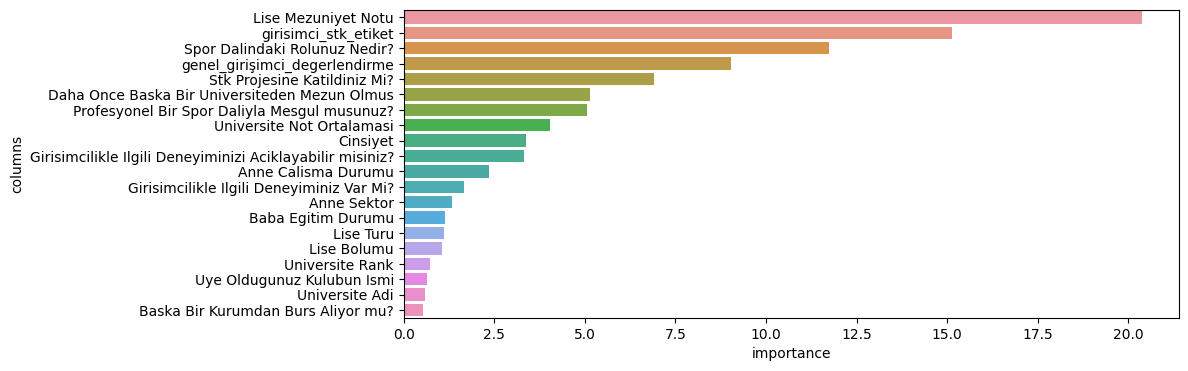

In [597]:
imp_df = pd.DataFrame()
imp_df["importance"] = model.feature_importances_
imp_df["columns"] = training_columns
imp_df.sort_values(by="importance", inplace=True, ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(data=imp_df.head(20), y="columns", x="importance")
plt.show()